In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import scipy.stats

In [9]:
p_a = .018 # assume we have a base click rate of 1,8% for our original design (A group)
p_b = .02 # we want to detect an increase in click rate to 2%, otherwise not worth changing the design

p = (p_a + p_b)/2.

In [10]:
Z8 = scipy.stats.norm.ppf(.8) # we will need this to ensure 80% power (20% false negative rate)
Z95 = scipy.stats.norm.ppf(1 - .05) # we will need this for 5% false positive rate (95% confidence level), one-tailed
Z975 = scipy.stats.norm.ppf(1 - .025) # 5% false positive rate for two-tailed case

ES = abs(p_b - p_a)/np.sqrt(p*(1-p))

num_tails = 1 # presumably we are testing design b because we think it will improve the click rate...

if num_tails == 2:
    n = 2*((Z975 + Z8)/ES)**2  # two-tailed
else:
    n = 2*((Z95 + Z8)/ES)**2 # one-tailed

print ('You need', round(n), ' samples in each group to get a 5% false positive and 20% false negative rate given effect size')

You need 57618.0  samples in each group to get a 5% false positive and 20% false negative rate given effect size


In [7]:
n_a = int(round(n))
n_b = int(round(n))

num_experiments = 10000

conversions_a = np.random.random((n_a, num_experiments)) < p_a
conversions_b_null = np.random.random((n_b, num_experiments)) < p_a
conversions_b = np.random.random((n_b, num_experiments)) < p_b

mean_a = np.mean(conversions_a, axis=0)
mean_b_null = np.mean(conversions_b_null, axis=0)
mean_b = np.mean(conversions_b, axis=0)

#s_a = np.std(conversions_a, ddof=1)
#s_b_null = np.std(conversions_b_null, ddof=1)
#s_b = np.std(conversions_b, ddof=1)
# equivalent:
s_a = np.sqrt(np.sum((conversions_a - mean_a[np.newaxis, :])**2, axis=0)/(n_a - 1))
s_b_null = np.sqrt(np.sum((conversions_b_null - mean_b_null[np.newaxis, :])**2, axis=0)/(n_b - 1))
s_b = np.sqrt(np.sum((conversions_b - mean_b[np.newaxis, :])**2, axis=0)/(n_b - 1))

sp = np.sqrt(s_a**2/n_a + s_b**2/n_b)
sp_null = np.sqrt(s_a**2/n_a + s_b_null**2/n_b)

if num_tails == 2:
    t = abs(mean_b - mean_a) / sp # two-tailed
    t_null = abs(mean_b_null - mean_a) / sp_null # two-tailed
    results = t > Z975  # two-tailed
    results_null = t_null > Z975  # two-tailed
else:
    t = (mean_b - mean_a) / sp # one-tailed
    t_null = (mean_b_null - mean_a) / sp_null # one-tailed
    results = t > Z95 # one-tailed
    results_null = t_null > Z95 # one-tailed

false_negative_rate = 1 - np.sum(results).astype('float')/len(results)
false_positive_rate = np.sum(results_null).astype('float')/len(results_null)

print (false_negative_rate, "false negative rate, we expect it to be close to 20%")
print (false_positive_rate, "false positive rate, we expect it to be close to 5%")

0.21499999999999997 false negative rate, we expect it to be close to 20%
0.0463 false positive rate, we expect it to be close to 5%


Text(0.016, 100, '5.0% false positives')

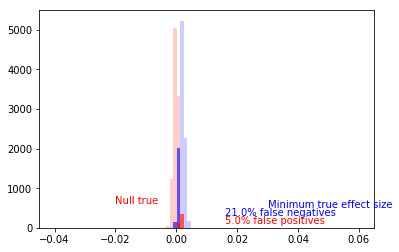

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

n, bins, p = ax.hist(mean_b - mean_a, np.linspace(-.04, .06, 88), color=[.8, .8, 1])
n, bins, p = ax.hist(mean_b_null - mean_a, bins, color=[1, .8, .8])

n, bins, p = ax.hist(mean_b[results==False] - mean_a[results==False], bins, color='b', alpha=.6)
n, bins, p = ax.hist(mean_b_null[results_null] - mean_a[results_null], bins, color='r', alpha=.6)

ax.text(-.02, 600, 'Null true', color='r')
ax.text(.03, 500, 'Minimum true effect size', color='b')

ax.text(.016, 300, str(round(false_negative_rate*100))+"% false negatives", color='b')
ax.text(.016, 100, str(round(false_positive_rate*100))+"% false positives", color='r')